## Summarize the centriole compensation

Required input:

For the midline: a list of X_coordinate and a list of Y_coordinate

For the edge: a list of X_coordinate and a list of Y_coordinate

For the centriole: a list of list containing [X_coordinate, Y_coordinate, an angle (in degrees)]

In [1]:
import import_ipynb

import torch
import torch.nn as nn

import time

import csv

from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *
from tools.Graphical_Tools import *
from tools.Centriole_Detection import *

#from tools.Worm_Segmentation import extract_worm_edge

importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\ToolBox.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Midline_Edge_Reformater.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Extract_Experiment_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\CNN_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Graphical_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Analysis_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Detection.ipynb


In [2]:

# Are  Midline and Edge already define in an excel file?
# Cyril's Note: For Schmidtea it's probably a better to perform a manual definition of the edge of the worm:
#         The segmentation is performed with the DIC 10x. As consequences:
#                 -> The edge of the worm where there is no centriole is included in the mask. In the Dev Cell, 2019, this zone was not taken into consideration
#                 -> It's always better (if possible) to use the 100x objective to draw the edge: there is chromatic aberration (not compensated so far) between 10x and 100x leading to mis calculation of the distance.
Load_Mid_and_Edge = True
pathExcel = './full_worm_2/160607_WT_Rootletin_6.xlsm'

# Are you just testing the angle compensation?
Test_Angle_Compensation = False



path_img_100x  = './full_worm_2/160607_WT_Rootletin_6.tif'
path_img_10x   = './full_worm/C1-180417_Dvl1&2_Odf2-injection_root_17dpa_10x_Full_1.tif'

problem = 'classification'


In [ ]:
t_ini = time.time()
#############################
# MIDLINE AND WORM EDGE       
#############################

# Load Midline and Edge coordinates from a 'classical' excel file
if Load_Mid_and_Edge:
    path = './full_worm/180417_Dvl1&2_Odf2-injection_root_17dpa_63x_Full_1.xlsm'

    db = get_xls_values(pathExcel)

    x_mid = db['worm_midline']['x']
    y_mid = db['worm_midline']['y']
    x_edg = db['worm_edge']['x']
    y_edg = db['worm_edge']['y']

    newY_mid, newY_edg = [], []
    for y in y_mid:
        newY_mid.append(-y)

    for y in y_edg:
        newY_edg.append(-y)
        
    print('Midline and Edge loaded')
    
    worm = [x_mid, newY_mid, x_edg, newY_edg ]

    
# Automatic characterization of the midline and the edge
## So far (17 November 2020) do not work at all. 
## Ideas: size of the image, contrast (rm background per example)
else:
    midline, edge = extract_worm_edge(path_img_10x, quantile = 0.01)
    worm = [midline[0], midline[1], edge[0], edge[1]]
    
    print('Midline and Edge computed')
    pass

########################################################################################

#+++++++++++++++++++++++++++++
# TO DO
# Adjust the midline with the edge of the worm'''
#
#+++++++++++++++++++++++++++++

# Reformat a midline and Edge in a given number of segment and subsegment
midline_final = aggregate_segment_char(x_mid, newY_mid, 
                                       x_edg, newY_edg, 
                                       n_midline_seg = 50, 
                                       n_sub_segment = 25, 
                                       n_edge_seg = 200)

print('Edge and Midline reformated')




###################################################
# CENTRIOLE IDENTIFICATION AND ANGLE PREDICTION  
###################################################

# This step is usefull here to get a list of centriole already treated
if Test_Angle_Compensation:
    import xlrd  

    xls_name = "./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm"

    with xlrd.open_workbook(xls_name) as xls_file:
        # Go to appropriate sheet (index 0)
        xls_sheet = xls_file.sheet_by_index(0)

    a_list_of_centriole = []

    pixel_size = db['image_pixel_size_in_um']
    x_shift = db['image_shift']['x']
    y_shift = db['image_shift']['y']

    for row in range(xls_sheet.nrows - 7):
        if isinstance(xls_sheet.cell_value(row + 7, 3), (float, int)):
            X = xls_sheet.cell_value(row + 7, 3)/pixel_size + x_shift
            Y = -(xls_sheet.cell_value(row + 7, 4)/pixel_size + y_shift)
            angle = xls_sheet.cell_value(row + 7, 1)

            a_list_of_centriole.append(((X, Y), angle))
        
        
# Extraction of the centriole and analysis from an raw image
# 17 November 2020: problem can only be 'classification' (with 72 classes)
else:
    # Identification of the Centrioles
    img = cv2.imread(path_img_100x, cv2.IMREAD_UNCHANGED)
    print('Image Loaded')

    dog_img = dog_and_otsu(img)
    print(time.asctime())
    
    find_maxima_img = find_maxima(img)
    print(time.asctime())
    
    combine_img = dog_img*find_maxima_img
    
    
    # Save of the intermediate images
    img_to_save = Image.fromarray(dog_img)
    newPath = path_img_100x[:-4] + '_dog_otsu.tif'
    img_to_save.save(newPath)

    img_to_save = Image.fromarray(find_maxima_img)
    newPath = path_img_100x[:-4] + '_find_maxima.tif'
    img_to_save.save(newPath)
    
    img_to_save = Image.fromarray(combine_img)
    newPath = path_img_100x[:-4] + '_centriole_detected.tif'
    img_to_save.save(newPath)
    
    
    # CUDA is way faster but not always available
    if torch.cuda.is_available():                                  
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Loading of the model
    if problem == 'classification':
        model = VGG_Schmidtea(n_classes = 72).to(device)
        model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth', map_location = device))
    else:
        model = VGG_Schmidtea(n_classes = 1).to(device)
        model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_regression.pth', map_location = device))
    
    model.eval()
    #+++++++++++++++++++++++++++++++++++++
    # I don't know how the centriole image will come but to do the prediction:
    
    # Extraction of coordinates where centrioles are
    ypts, xpts = np.where(combine_img == 1)
    
    a_list_of_centriole = []
    
    x_shape, y_shape = img.shape[1], img.shape[0] 
    xlim, ylim  = x_shape - 16 , y_shape - 16
    for i in range(len(ypts)):
        x, y = xpts[i], ypts[i]
        
        if y > 16 and x > 16 and y < ylim and x < xlim:
            #centriole_extracted = img.crop((xpts[i], ypts[i], xpts[i] + 32, ypts[i] + 32))
            centriole = img[y-16:y+16, x-16:x+16]
            centriole = np.asarray(centriole, dtype = "uint8")
            centriole = centriole.reshape(1 , 1, 32, 32)
            # Inside predictor:
            centriole = torch.from_numpy(centriole)
            centriole = centriole.float().to(device)
            
            with torch.no_grad():
                output = model(centriole)
            
            angle = output.max(1)[1]
            angle = angle.numpy()
            
            #print(centriole_extracted)
            #angle = predictor(model, centriole_extracted, device, problem = 'classification')
            a_list_of_centriole.append(((xpts[i], ypts[i]), angle[0]))


print('Centrioles angle predicted and compensated')
print(time.asctime())


###############################################
# CENTRIOLE REPOSITIONNING ET REORIENTATION
###############################################

shiftX = db['image_shift']['x']
shiftY = db['image_shift']['y']
shifted_centriole_list = []

for a_centriole in a_list_of_centriole:
    xShifted = a_centriole[0][0] + shiftX
    yShifted = a_centriole[0][1] + shiftY
    if problem == 'classification':
        shifted_centriole_list.append(((xShifted, -yShifted),a_centriole[1]*5-2.5))
    else:
        shifted_centriole_list.append(((xShifted, -yShifted),a_centriole[1]))
    
    

reoriented_centriole = []
for a_centriole in shifted_centriole_list:
    tmp_list = list(centriole_characterizator(a_centriole, midline_final))
    if db['worm_orientation'] == 'gauche' or db['worm_orientation'] == 'left':
        tmp_list[-2] = 1 - tmp_list[-2]
        tmp_list[-1] = math.degrees(math.atan2(-math.sin(math.radians(tmp_list[-1])), -math.cos(math.radians(tmp_list[-1]))))
    tmp_list.insert(1,a_centriole[0][0])
    tmp_list.insert(2,a_centriole[0][1])

    reoriented_centriole.append(tmp_list)

# SAve
newPath = path_img_100x[:-4] + '_DATA.csv'
with open(newPath, 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(reoriented_centriole)

    
print('Centriole Dataset reformated')
print(time.asctime())


t_final = time.time()

print(f"Time: {t_final-t_ini}" )

File loaded: ./full_worm_2/160607_WT_Rootletin_6.xlsm
Midline and Edge loaded
Edge and Midline reformated
Image Loaded
Image transformed in uint8
Differential of Gaussian performed
Thresholding performed
Object size thresholded


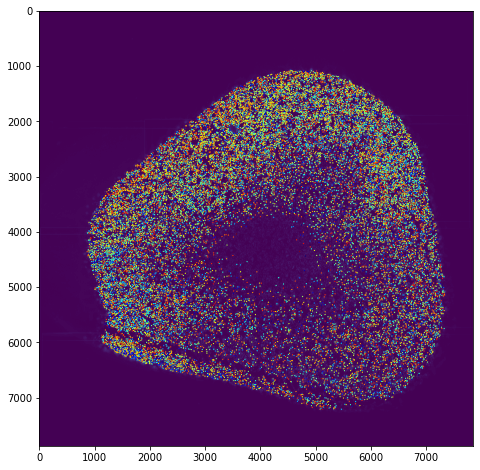

In [29]:
# Overlap the analysed image with the identified and analyzed centriole represented as an arrow indicating the predicted angle
# The starting point of the arrow is the origin of the detected centriole
# The Ending point indicate the predicted orientation of the centriole

save_figure = True

# Each color correspond to a class of 5°
# So far the color or 'randomly' attributed for each class

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Define the length of the arrow
arrowLen = 5

# Compute as X/Y coordinates the property of the arrow
# WARNING: 18/11/2020. FOR AN UNKNOWN REASON, the angle is rotated by 90° -> I need to check why
DATA = []

for i in a_list_of_centriole:
    angle = i[1] + 90
    x = i[0][0]
    y = i[0][1]
    new_coord = [x-arrowLen*math.cos(math.radians(angle)), y-arrowLen*math.sin(math.radians(angle)), x+arrowLen*math.cos(math.radians(angle)), y+arrowLen*math.sin(math.radians(angle)), angle]
    DATA.append(new_coord)
    
DATA = np.array(DATA)

cmap = plt.cm.jet
cNorm  = colors.Normalize(vmin=np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

plt.figure(figsize=(100,50))

plt.imshow(img)

for idx in range(0,len(DATA[:,1])):
    colorVal = scalarMap.to_rgba(DATA[idx,4])
    plt.arrow(DATA[idx,0],  #x1
              DATA[idx,1],  # y1
              DATA[idx,2]-DATA[idx,0], # x2 - x1
              DATA[idx,3]-DATA[idx,1], # y2 - y1
              color=colorVal)
if save_figure: 
    savePath = path_img_100x[:-4] + '_detection_angle.tif'
    plt.savefig(savePath)
    
plt.show()  

 Idx | Angle |Lateral| Longi   || Marker | Color
------------------------------------------------
   0 | -111  |  0.84 |  0.32   ||   o    | darkorange


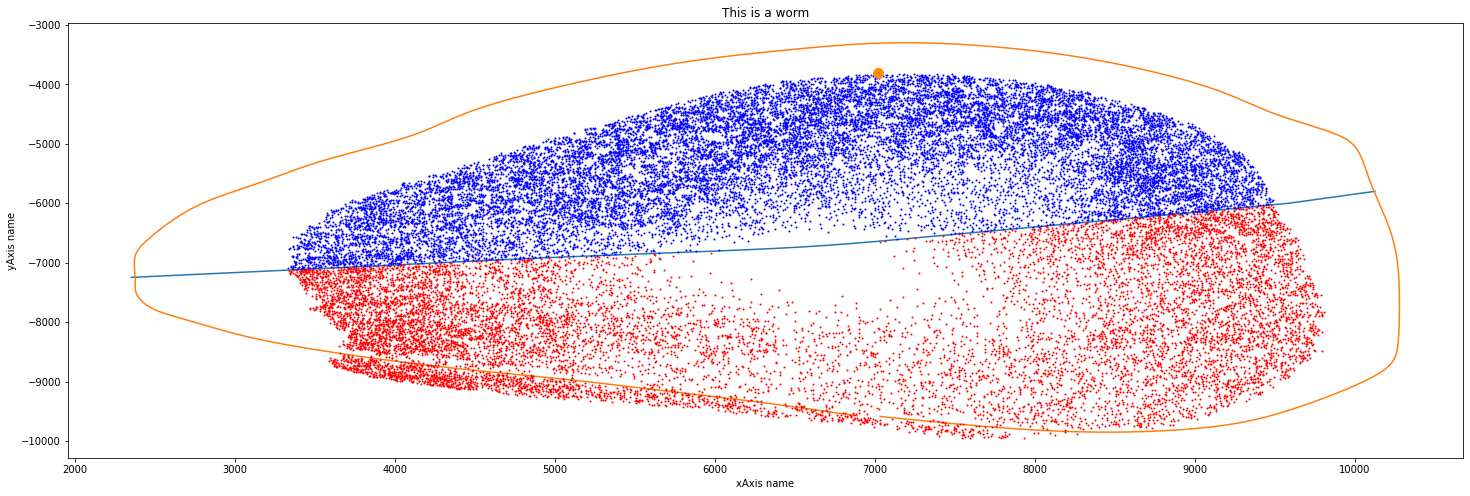

In [90]:
# Graphical Representation of the worms and the analyzed centrioles
# If you want to see some specific centrioles, add them in the list
list_of_desired_centriole = [0]

# If you want to see the location of a specific coordinate (Write None if you don't want to see them )
X_coordinate = None
Y_coordinate = None

save_path = path_img_100x[:-4] + '_schema.csv'
Worm_And_Centriole(reoriented_centriole, worm, list_of_desired_centriole, (X_coordinate, Y_coordinate), save_path, save = True)

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


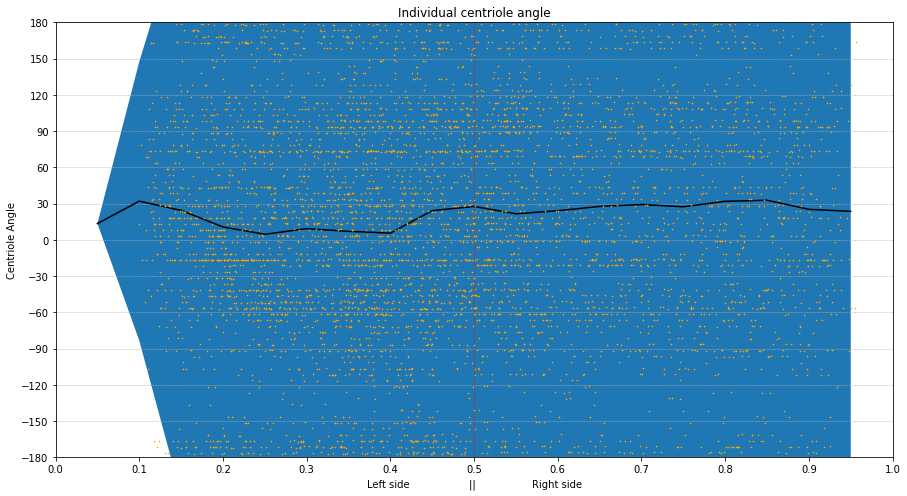

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


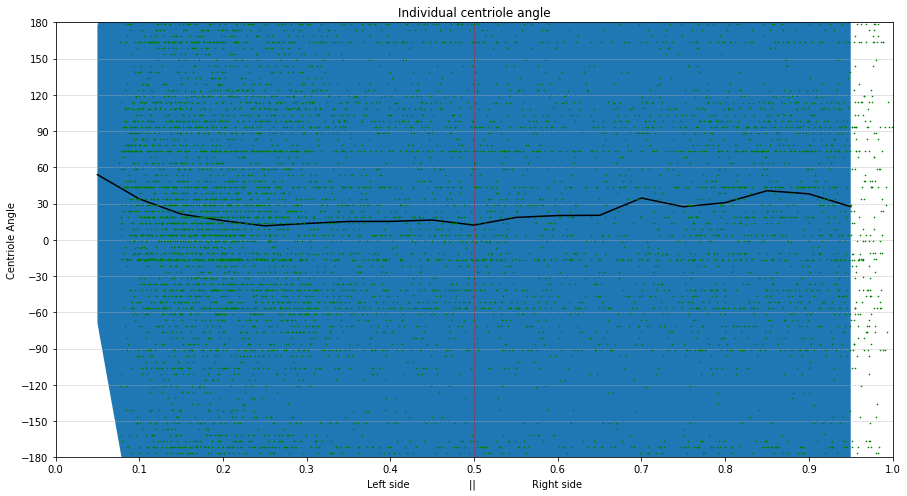

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


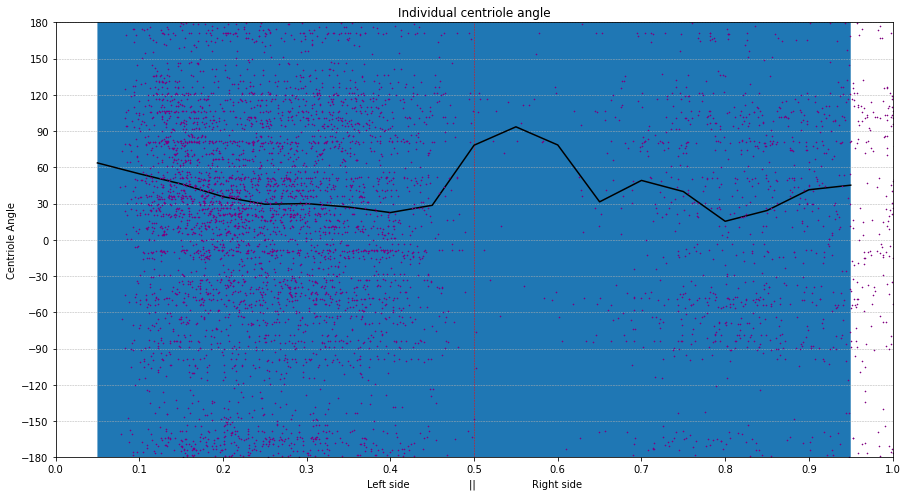

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


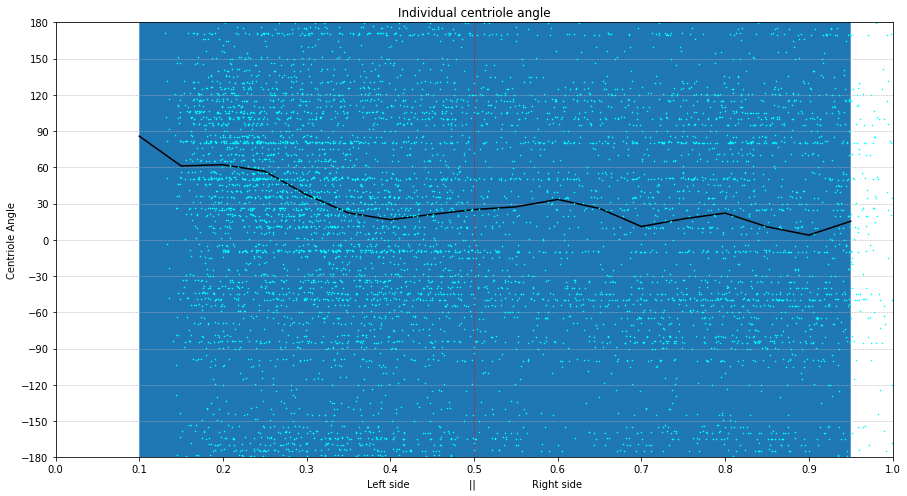

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


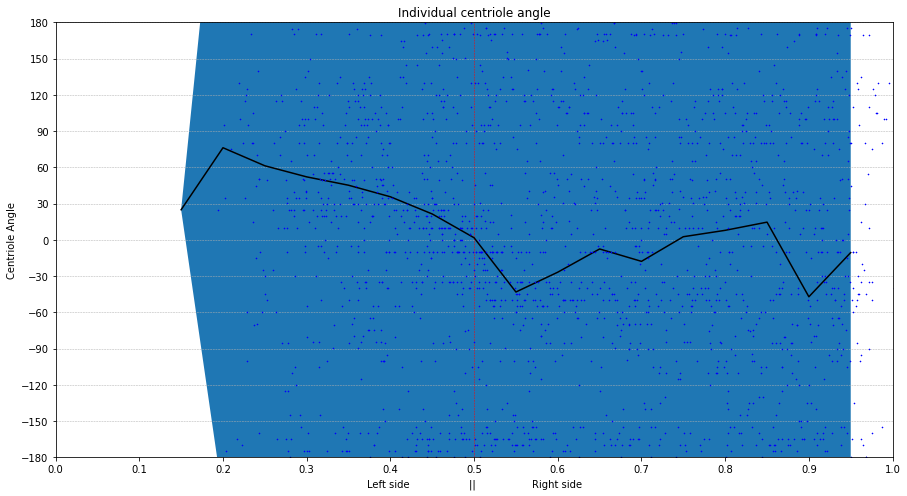

In [91]:
# Graphical representation of the results 

for i in range(5):
    print_a_antero_posterior_result(reoriented_centriole, i, n_ante_post_segment = 5, a_lat_size = 0.1, a_lat_step = 0.05)

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import csv

import import_ipynb

from tools.ToolBox import json_loader
from tools.ToolBox import csv_saver

from tools.CNN_Tools import VGG_Schmidtea
from tools.CNN_Tools import train
from tools.CNN_Tools import validate

from tools.Dataset_Tools import centriole_dataset
from tools.Dataset_Tools import dataset_creator
from tools.Dataset_Tools import dataset_loader
from tools.Dataset_Tools import dataset_aggregator

In [2]:
problem = 'regression'
problem = 'classification'


if problem == 'classification':
    n_class = 72
    
else:
    n_class = 1

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++